In [1]:
%pip install davos
import davos
davos.config.suppress_stdout = True

Note: you may need to restart the kernel to use updated packages.


In [90]:
from bs4 smuggle BeautifulSoup     # pip: beautifulsoup4==4.12.2
smuggle requests                   # pip: requests==2.28.2
smuggle spacy                      # pip: spacy==3.1.3
from tqdm smuggle tqdm             # pip: tqdm==4.65.0
smuggle textract                   # pip: textract==1.6.4
smuggle Levenshtein                # pip: levenshtein
smuggle fuzzywuzzy                 # pip: fuzzywuzzy==0.18.0
smuggle unidecode                  # pip: Unidecode==1.3.6
smuggle pandas as pd               # pip: pandas==2.0.1
smuggle numpy as np                # pip: numpy==1.24.3
smuggle seaborn as sns             # pip: seaborn==0.12.2
from matplotlib smuggle pyplot as plt  # pip: matplotlib==3.7.1
from IPython.display import Markdown

from nltk.tokenize smuggle word_tokenize, sent_tokenize  # pip: nltk==3.8.1
from nltk import pos_tag

smuggle re
smuggle os
smuggle urllib
smuggle json
smuggle string
smuggle warnings
from glob smuggle glob as lsdir

from pathlib smuggle Path

from helpers smuggle format_filename, get_soup, get_pdf_text, get_doc_text, get_dialogue

try:
    nlp = spacy.load('en_core_web_sm')
except:
    os.system('python -m spacy download en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jmanning/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/jmanning/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [104]:
def count_tenses_in_directory_spacy(directory_path):
    # Initialize DataFrame
    df = pd.DataFrame(columns=['filename', 'past_tense', 'future_tense'])
    
    for filename in os.listdir(directory_path):
        if filename.endswith('.txt'):
            filepath = os.path.join(directory_path, filename)
            
            with open(filepath, 'r', encoding='utf-8') as f:
                text = f.read()
            
            doc = nlp(text)
            past_count = 0
            future_count = 0

            for sent in doc.sents:
                tense = None
                
                for token in sent:
                    # Checking for past tense
                    if token.tag_ in ['VBD', 'VBN']:
                        tense = 'past'
                        break

                    # Checking for future tense
                    if ('will' in [child.lemma_.lower() for child in token.children] or \
                        ('be' in token.lemma_.lower() and 'to' in [child.lemma_ for child in token.children]) or \
                        token.lemma_ == 'going' and 'to' in [child.lemma_ for child in token.children]):
                        tense = 'future'
                        break
                
                if tense == 'past':
                    past_count += 1
                elif tense == 'future':
                    future_count += 1
            
            # Append the counts for each file to the DataFrame
            new_row = {'filename': filename, 'past_tense': past_count, 'future_tense': future_count}
            df = df._append(new_row, ignore_index=True)
            
    return df

In [93]:
def count_tenses_in_directory_nltk(directory_path):
    df = pd.DataFrame(columns=['filename', 'past_tense', 'future_tense'])
    
    for filename in os.listdir(directory_path):
        if filename.endswith('.txt'):
            filepath = os.path.join(directory_path, filename)

            with open(filepath, 'r', encoding='utf-8') as f:
                text = f.read()

            sentences = sent_tokenize(text)
            past_count = 0
            future_count = 0

            for sentence in sentences:
                # Expand contractions for better matching
                sentence = re.sub(r"won't", "will not", sentence)
                sentence = re.sub(r"can't", "cannot", sentence)
                sentence = re.sub(r"i'm", "i am", sentence)
                sentence = re.sub(r"ain't", "is not", sentence)
                sentence = re.sub(r"(\w+)'ll", "\\1 will", sentence)
                sentence = re.sub(r"(\w+)n't", "\\1 not", sentence)
                sentence = re.sub(r"(\w+)'ve", "\\1 have", sentence)
                sentence = re.sub(r"(\w+)'s", "\\1 is", sentence)
                sentence = re.sub(r"(\w+)'re", "\\1 are", sentence)

                # POS tagging
                words = word_tokenize(sentence)
                pos_tags = pos_tag(words)

                # Check for past tense using POS tags
                if any(tag == 'VBD' for word, tag in pos_tags):
                    past_count += 1
                
                # Check for "have" or "has" followed by a past participle (VBN)
                if any(tag == 'VBN' and (pos_tags[i-1][0].lower() == 'have' or pos_tags[i-1][0].lower() == 'has') for i, (word, tag) in enumerate(pos_tags)):
                    past_count += 1
                
                # Check for future tense patterns
                if re.search(r'\bwill\b|\bshall\b|\bam going to\b|\bwill have\b|\bshall have\b|\bwill be\b|\bshall be\b|\b(is|are) going to\b|\b(is|are|am) about to\b|\b(is|are|am) planning to\b|\b(is|are|am) looking forward to\b', sentence, re.IGNORECASE):
                    future_count += 1

            df = df._append({'filename': filename, 'past_tense': past_count, 'future_tense': future_count}, ignore_index=True)

    return df

In [123]:
def count_tenses_in_directory(directory_path):
    # Initialize DataFrames
    count_df = pd.DataFrame(columns=['filename', 'past_tense', 'future_tense'])
    sentence_df = pd.DataFrame(columns=['filename', 'sentence_num', 'sentence_text', 'past_references', 'future_references'])
    
    for filename in os.listdir(directory_path):
        if filename.endswith('.txt'):
            filepath = os.path.join(directory_path, filename)
            
            with open(filepath, 'r', encoding='utf-8') as f:
                text = f.read()
            
            doc = nlp(text)
            past_count = 0
            future_count = 0
            sentence_num = 0

            for sent in doc.sents:
                sentence_num += 1
                past_references = False
                future_references = False
                
                # Strip leading and trailing whitespace
                stripped_sent = sent.text.strip()
                
                for token in nlp(stripped_sent):
                    # Checking for past tense
                    if not past_references and token.tag_ in ['VBD', 'VBN']:
                        past_references = True

                    # Checking for future tense
                    if not future_references and \
                       ('will' in [child.lemma_.lower() for child in token.children] or \
                        ('be' in token.lemma_.lower() and 'to' in [child.lemma_ for child in token.children]) or \
                        token.lemma_ == 'going' and 'to' in [child.lemma_ for child in token.children]):
                        future_references = True
                
                if past_references:
                    past_count += 1
                if future_references:
                    future_count += 1
                
                # Append sentence-level details
                if past_references or future_references:
                    new_row = {
                        'filename': filename, 
                        'sentence_num': sentence_num,
                        'sentence_text': stripped_sent, 
                        'past_references': int(past_references),
                        'future_references': int(future_references)
                    }
                    sentence_df = sentence_df._append(new_row, ignore_index=True)
                    
            # Append the counts for each file to the DataFrame
            new_row = {'filename': filename, 'past_tense': past_count, 'future_tense': future_count}
            count_df = count_df._append(new_row, ignore_index=True)
            
    return count_df, sentence_df

In [124]:
chair_transcripts_dir = str(Path.cwd().parent.joinpath('data', 'the_chair'))
# chair_df_nltk = count_tenses_in_directory_nltk(chair_transcripts_dir)
# chair_df_spacy = count_tenses_in_directory_spacy(chair_transcripts_dir)
chair_df, chair_sentence_df = count_tenses_in_directory(chair_transcripts_dir)

In [126]:
chair_df

,filename,past_tense,future_tense
0,the_chair_s1e5_transcript.txt,123,4
1,the_chair_s1e2_transcript.txt,79,5
2,the_chair_s1e3_transcript.txt,119,10
3,the_chair_s1e4_transcript.txt,112,11
4,the_chair_s1e6_transcript.txt,125,20
5,the_chair_s1e1_transcript.txt,107,8


In [121]:
from IPython.display import display, Markdown

def display_sentences_in_markdown(df):
    for idx, row in df.iterrows():
        markdown_text = f"### File: {row['filename']}\n\n"
        markdown_text += f"**Sentence Number:** {row['sentence_num']}\n\n"
        markdown_text += f"**Sentence:** {row['sentence_text']}\n\n"
        markdown_text += f"**Past References:** {row['past_references']}\n\n"
        markdown_text += f"**Future References:** {row['future_references']}\n\n"
        markdown_text += "---"
        display(Markdown(markdown_text))

In [127]:
display_sentences_in_markdown(chair_sentence_df)

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 1

**Sentence:** [Larson] Did you at any point threaten Bill’s TA?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 6

**Sentence:** Did you say she could get hurt if she talked to the student newspaper?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 11

**Sentence:** I mentioned that the… the department could get hurt if we…

Pembroke Daily is running an article suggesting you issued a gag order.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 13

**Sentence:** Did you have a conversation with Bill’s TA

in which you asked her not to discuss Bill’s incident?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 16

**Sentence:** That is certainly not what I meant to convey.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 17

**Sentence:** Students are already mobilized,

and we’re concerned that this is going to exacerbate things on campus.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 24

**Sentence:** I’ve drafted a letter from both you and Dean Larson

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 25

**Sentence:** alerting Professor Dobson that next week’s hearing

will be on termination for cause.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 31

**Sentence:** In order to fire a tenured professor, don’t you have…

Tenure is not a blank check anymore.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 34

**Sentence:** And we heard about him lecturing hungover and showing nude photos in class.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 35

**Sentence:** Or nude videos, I think it was.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 37

**Sentence:** That was…

Getting rides from female students.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 38

**Sentence:** That happened once.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 43

**Sentence:** So you knew about him with a coed?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 44

**Sentence:** I mean, did she complain?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 50

**Sentence:** His wife died a year ago.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 53

**Sentence:** If I were a man, would you ask me that?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 55

**Sentence:** The three of you left campus yesterday in the same car.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 56

**Sentence:** Only because his was in the shop.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 57

**Sentence:** If you are romantically involved, you need to declare it,

or you yourself are in violation of university policy.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 64

**Sentence:** You’ve managed to do the opposite.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 84

**Sentence:** I told you it can’t happen today.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 106

**Sentence:** Duly fucking noted.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 110

**Sentence:** There was a mishap at Bill’s.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 120

**Sentence:** [in Korean] I thought this promotion means you don’t have to work so much.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 133

**Sentence:** She’s mad at me because she was supposed to work on her Mexico presentation

this morning with Bill.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 159

**Sentence:** I didn’t know anybody was here.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 164

**Sentence:** The, uh… The door was open.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 166

**Sentence:** Never had a problem before.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 177

**Sentence:** For a second, I thought you were naked.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 203

**Sentence:** [smacks lips]

Will there be cake?

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 205

**Sentence:** You left this at the copier.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 206

**Sentence:** Uh, you’re not supposed to read this.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 207

**Sentence:** I only glanced at the first few sentences to see what it was.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 210

**Sentence:** Okay, let’s move on from the argument

about whether or not I should’ve looked at it,

and just get to the real argument here.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 213

**Sentence:** I offered a positive assessment of your scholarship.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 226

**Sentence:** Ji-Yoon came to me and begged me to co-teach with you

because your enrollments were so low.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 229

**Sentence:** [Yaz] You were on a list.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 230

**Sentence:** They were gonna force you to retire.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 232

**Sentence:** So she merged us so that you could piggyback on my enrollments.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 243

**Sentence:** [gasps]

Have you heard about a list?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 245

**Sentence:** We gotta band together.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 248

**Sentence:** [farts]

Was that you or me?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 250

**Sentence:** For the Distinguished Lectureship,

I was thinking of presenting my Yale dissertation.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 252

**Sentence:** I only wrote the one chapter.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 256

**Sentence:** Did you use really big font?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 259

**Sentence:** I got sidetracked for a few decades,

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 261

**Sentence:** I’ve been thinking recently about finishing it and filing for my PhD.

Dr. David Duchovny.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 271

**Sentence:** I think it’s pronounced “prescient,” unless we’re English.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 273

**Sentence:** I mean, maybe you chose the wrong department.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 274

**Sentence:** Maybe you’re better suited for the schiences.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 288

**Sentence:** [David] Have you been to the farmers’ market here?

**Past References:** 1

**Future References:** 1

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 292

**Sentence:** I used to think this town was devoid of culture,

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 293

**Sentence:** but I stand corrected.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 305

**Sentence:** Why didn’t she adopt a baby from South Korea?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 309

**Sentence:** She was closed out from international adoption

because she’s single.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 311

**Sentence:** and she was able to adopt.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 357

**Sentence:** A lot has happened in the last 30 years.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 360

**Sentence:** When’s the last time you picked up an academic journal?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 363

**Sentence:** I’ve been on tour with my band.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 377

**Sentence:** Is this hostility because Pembroke

is like this lower-tier Ivy, and I went to Princeton?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 386

**Sentence:** This is hostility

because I promised this Distinguished Lectureship

to someone who deserves it.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 390

**Sentence:** The discipline has moved forward,

and you’re still stuck back in a different era.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 397

**Sentence:** No, it’s been so long since they broke up.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 406

**Sentence:** Habi said they picked him up off the street.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 410

**Sentence:** [David singing indistinctly]

Only song I’ve ever heard quote Wallace Stevens.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 417

**Sentence:** Was there someone else before me?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 421

**Sentence:** Did Pembroke offer this position to someone else first?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 424

**Sentence:** There was talk of James Franco a while back.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 428

**Sentence:** Well, he got his PhD from Yale.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 430

**Sentence:** Oh, did he?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 432

**Sentence:** Oh, he got it?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 437

**Sentence:** He did.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 438

**Sentence:** He did.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 439

**Sentence:** They might’ve invited Ethan Hawke, but he was shooting in Bulgaria.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 440

**Sentence:** What was he shootin’?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 448

**Sentence:** I don’t know what he was shooting.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 452

**Sentence:** [exhales]

Look, so I did all that work at Yale on Beckett, right?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 461

**Sentence:** Um, whose… Who… Who wore that?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 463

**Sentence:** Oh, it’s mine.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 469

**Sentence:** You got Murphy, Molloy, Malone Dies…

The students bought the other books.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 472

**Sentence:** I’m a grossly overpaid actor/musician/novelist,

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 473

**Sentence:** and they’re students burdened with student debt.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 474

**Sentence:** I will unburden them.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 481

**Sentence:** If you really wanna make a contribution to the field,

tell them you’ve changed your mind.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 542

**Sentence:** [all cheering]

That lady right there, she rigged it.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 545

**Sentence:** She rigged the process.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 548

**Sentence:** She wanted the paintbrush.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 556

**Sentence:** She wanted the paintbrush.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 562

**Sentence:** I mean, one of the reasons I went into this

was that you don’t age out.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 565

**Sentence:** I never thought I’d retire.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 572

**Sentence:** You got your glucose tablets?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 581

**Sentence:** I, um…

I’ve been, uh…

I’ve been here for what, 32 years, was chair for six of those,

and nothing like this ever happened.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 584

**Sentence:** Well, she wanted me to doctor my tenure letter for Yaz

in exchange for co-teacher.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 585

**Sentence:** I get put on a list.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 589

**Sentence:** [chuckling] I can’t take you seriously

when you look like you just stuck your head in a beehive.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 595

**Sentence:** Now, if one of us had stepped out of line,

she would not be going to the mat like this.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 598

**Sentence:** Well, we elected her.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 601

**Sentence:** She’s only protected his.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 603

**Sentence:** We gotta do something.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 608

**Sentence:** I’ve got great news.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 609

**Sentence:** David Duchovny’s not giving the Distinguished Lectureship,

you are.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 611

**Sentence:** I already agreed to give it somewhere else.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 618

**Sentence:** They’ve invited me to apply for a position.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 619

**Sentence:** Why didn’t you tell me?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 620

**Sentence:** [breathes deeply]

Look, I know it’s been a mess around here.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 622

**Sentence:** I mean, I’ve been a mess.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 630

**Sentence:** Seeded by benefactors who got rich off of sugar

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 641

**Sentence:** You think that’s how I got here?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 643

**Sentence:** Is that how you think I fucking got here?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 646

**Sentence:** You are gonna be the first tenured Black woman in the department.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 650

**Sentence:** Pembroke said and did all the right things to keep me here.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 652

**Sentence:** But you know the real reason I stayed?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 654

**Sentence:** It was because of Joan,

and Bill,

and this dazzling new hire named Yaz.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 667

**Sentence:** [inhales deeply]

Expedited tenure and an endowed professorship.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 675

**Sentence:** You didn’t have to do that.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 695

**Sentence:** How long ago did he lose his wife?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 697

**Sentence:** It’s been about a year.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 702

**Sentence:** And he wrote a book, maybe two?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 705

**Sentence:** I hope I didn’t mess it up.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 719

**Sentence:** If only there were a good Korean woman in his life.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 723

**Sentence:** Not bad-looking if he’d only shave.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 725

**Sentence:** And he’s good with kids.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 736

**Sentence:** Ju Ju, your mom got home early.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 748

**Sentence:** Um, what did Ji-Yoon pick for her Dol ceremony?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e5_transcript.txt

**Sentence Number:** 751

**Sentence:** Yeah, she picked a pencil.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 3

**Sentence:** His wife died.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 12

**Sentence:** You just gave your pie to a Nazi.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 13

**Sentence:** [classical music playing]

I left her dinner in the fridge.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 22

**Sentence:** I gotta go.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 31

**Sentence:** [sighs] That, you heard.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 37

**Sentence:** She’ll make an appearance as soon as I’m gone.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 43

**Sentence:** That’s what the girl I stole it from said.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 46

**Sentence:** [Ju Ju in high-pitched voice]

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 67

**Sentence:** What happened?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 70

**Sentence:** What did she do?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 73

**Sentence:** [Vicky sighs]

I don’t wanna say that I was triggered by your daughter,

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 89

**Sentence:** Didn’t you get a raise recently?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 91

**Sentence:** [in English] I had one.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 92

**Sentence:** She had to cancel at the last minute.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 105

**Sentence:** Oh, did you bake this yourself?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 120

**Sentence:** I did not dare to eat it.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 131

**Sentence:** Where’s she supposed to sleep?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 149

**Sentence:** [Yaz sighs]

[indistinct chatter]

I got your email about Fre… Fr…

Yasmin McKay.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 170

**Sentence:** For the last five years,

you’ve put the same picture of me on our recruitment brochure.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 173

**Sentence:** As soon as one of them retires,

gets kicked out,

or dies.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 178

**Sentence:** Well, if it were up to them,

we’d all be teaching at home in our skivvies.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 179

**Sentence:** [McHale chuckles] Speaking of which, how did your colonoscopy go?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 205

**Sentence:** I spent half of grad school in there.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 227

**Sentence:** You’re over-enrolled, right?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 228

**Sentence:** “Professor Dobson’s class

is like the limp-dicked version of his pretentious writing.”

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 230

**Sentence:** So they read your book.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 233

**Sentence:** Hey, I called you earlier.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 235

**Sentence:** Yeah, I left the phone at home.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 236

**Sentence:** Doodles said I’m texting too much, so…

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 244

**Sentence:** Wish I had done that.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 245

**Sentence:** Back when I was cute,

my head was buried in Piers Plowman and Dream of the Rood.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 251

**Sentence:** Deftly done.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 305

**Sentence:** …then you will have successfully checked every box

in the disaffected middle-aged white-male-professor cliché.

**Past References:** 1

**Future References:** 1

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 341

**Sentence:** I’m excited to have you bring fresh ideas

into one of our most venerated departments.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 347

**Sentence:** I just gotta…

[all applauding]

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 349

**Sentence:** You got this.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 362

**Sentence:** You know, I have been thinking a lot about this generation of students,

and… and, you know, why they’re not interested in literature.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 366

**Sentence:** They must think, “Why am I scanning this sonnet

when there are so many things to be worried about?”

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 381

**Sentence:** The Distinguished Lectureship this year will be given by Professor Yasmin McKay,

the first woman of color to receive this honor in Pembroke’s entire history.

**Past References:** 1

**Future References:** 1

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 408

**Sentence:** Joan, I see you’ve introduced yourself to the bar.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 419

**Sentence:** Was just selected the best essay of the year in PMLA.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 426

**Sentence:** Back when I was 32, my…

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 431

**Sentence:** I will be right back.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 436

**Sentence:** I gotta go.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 444

**Sentence:** No, you smoked the whole thing.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 448

**Sentence:** [softly] You smoked the whole thing.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 459

**Sentence:** [Habi] This time she went out the window.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 462

**Sentence:** This has happened before?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 468

**Sentence:** Did she say anything?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 471

**Sentence:** She just talked about Hello Kitty.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 475

**Sentence:** She had to leave him at home

because my dad hasn’t recovered from the Japanese occupation.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 478

**Sentence:** Um…

Maybe she went home.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 483

**Sentence:** [in Korean] Ann Arbor was ranked No. 1

on WalletHub’s latest list of best college towns.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 484

**Sentence:** Appa…

You could be in Michigan married to Peter Seung right now with a real family,

and not pining for this crumpled man.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 485

**Sentence:** I have a real family, and Bill’s not crumpled up.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 528

**Sentence:** Last time I saw you, you were this big, and now you’re like this giant…

Listen, that is your one and only halahbojee.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 529

**Sentence:** He is all we’ve got.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 530

**Sentence:** When I was a kid, never in a million…

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 537

**Sentence:** Did… Did someone say that to you again?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 538

**Sentence:** Was it what’s-her-name?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 539

**Sentence:** Know what I’d like to do to that fucking kid?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 540

**Sentence:** I’d like… [breathes deeply]

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 544

**Sentence:** You guys like fried chicken?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 555

**Sentence:** [Bill] We did the party.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 557

**Sentence:** You gave a very memorable speech.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 575

**Sentence:** [Bill] Yeah, I think I got it.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 581

**Sentence:** I didn’t bring it.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 584

**Sentence:** I got everything I need right here.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 585

**Sentence:** I got fries, I got a beer,

I got a beautiful and talented bowling companion and her mother.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 627

**Sentence:** You know, for two years, I was like…

“What if I don’t get a baby?”

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 629

**Sentence:** “What if I don’t get a… What if I don’t match with anyone?”

[inhales deeply]

It never occurred to me… [chuckles]

…how it would actually be when I…

All the other moms in Mommy and Me

were just whipping out their boobs and, like…

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 630

**Sentence:** They all seemed so ready…

so natural, whereas I was like…

[chuckles]

Remember when you had to make that little book for the adoption agency?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 635

**Sentence:** You’re a fucking menace when it comes to anything that needs to be heated.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 636

**Sentence:** Why did she pick me?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 638

**Sentence:** How did I match with her?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 642

**Sentence:** I mean, to be her father.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 648

**Sentence:** Well, maybe Ju Ju’s birth mother

was raised by a really strong single mom,

and saw the pictures of you, and was like,

“She’s the one.”

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 657

**Sentence:** [Bill exhales]

[tugging seatbelt]

Oh God, it’s stuck.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 747

**Sentence:** If we got together, no one is gonna take me seriously.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 774

**Sentence:** You did it.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 776

**Sentence:** You ascended the ranks of your profession.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e2_transcript.txt

**Sentence Number:** 781

**Sentence:** Value added?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 5

**Sentence:** I will not embarrass the Fatherland.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 8

**Sentence:** Know how many times I’ve been in trouble for real shit?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 16

**Sentence:** I told you to pull it together.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 17

**Sentence:** I left it crooked ’cause I like it when you fix me up.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 27

**Sentence:** No, but that does remind me of this time when two Nazis walked into a bar…

[laughs]

We have a straightforward protocol for this sort of situation.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 53

**Sentence:** I’m tenured.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 55

**Sentence:** Universities are supposed to encourage dissent.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 59

**Sentence:** In fact, when I was an undergrad,

I sat bare-ass on that very desk for South African divestment.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 69

**Sentence:** If it’s not resolved immediately,

I wouldn’t be surprised if he asks for Bill’s resignation.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 75

**Sentence:** Well, I can guarantee that after our next conversation,

he will be filled with remorse.

**Past References:** 1

**Future References:** 1

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 80

**Sentence:** You should’ve seen your face in there.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 99

**Sentence:** This little streak of arrogance you got going on here.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 101

**Sentence:** Am I not allowed…

This is not about whether you’re a Nazi.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 106

**Sentence:** Yaz hit 8,000 Twitter followers,

so I posted that to the department’s website.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 108

**Sentence:** You posted she won the NEH Fellowship?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 112

**Sentence:** There’s gotta be something we can do.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 117

**Sentence:** I know it seems like I have been ignoring you,

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 118

**Sentence:** but it’s just been chaos.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 131

**Sentence:** My friend Sarah at Wisconsin, her adviser got accused of harassment,

and his recommendation ended up being worthless.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 135

**Sentence:** It was a bad joke, and he is about to apologize.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 136

**Sentence:** People have been calling me.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 147

**Sentence:** [Rentz] Moby-Dick was a failure, of course.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 148

**Sentence:** Critics hated it, and Melville died in obscurity,

as he himself had predicted in letters to his friend, Nathaniel Hawthorne,

to whom he dedicated the book.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 149

**Sentence:** Not until the 1920s was it reappraised as the seminal master…

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 150

**Sentence:** Are we going to discuss the fact that Melville was a wife-beater?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 151

**Sentence:** [students murmuring]

It is true that some feminist scholars have posited that,

but in the absence of definitive proof,

well, I…

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 157

**Sentence:** But you just referred to Melville the human being.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 159

**Sentence:** [students murmuring]

I was only making the point that his, uh, his friendship with Hawthorne was, uh,

was an important aspect of his growth as a writer.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 162

**Sentence:** It was not until the 1920s

that the novel took its rightful place as the…

We’ll cover the wife-beating in my section.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 167

**Sentence:** Who told you that?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 172

**Sentence:** It’s gone way beyond just the students in our class.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 181

**Sentence:** You tried tech support?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 182

**Sentence:** I’ve already left 700 messages.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 186

**Sentence:** I gotta go nudge Rentz.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 187

**Sentence:** But I will bring it up to Larson tonight.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 200

**Sentence:** And what did they say?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 203

**Sentence:** Was he always in here?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 205

**Sentence:** Oh, I haven’t had time to redecorate.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 206

**Sentence:** I gave him a hand job in his car

when I got tenure.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 210

**Sentence:** Who looks like the guy I gave a hand job to.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 226

**Sentence:** Now, if it were Elliot, or even you, I’d be worried.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 245

**Sentence:** This is going to be a bloodbath.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 247

**Sentence:** See, any so-called jokes related to Hitler are in their own special category.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 248

**Sentence:** You know some kids put on Hitler mustaches and posted knockoffs of your meme?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 253

**Sentence:** To be Jewish with all these militias?

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 254

**Sentence:** Last year, we had the largest number of anti-Semitic incidents in 40 years.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 255

**Sentence:** Of course intent matters, but even if you meant no harm,

if the impact of something that you did has…

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 261

**Sentence:** I was just, um, telling him the same thing.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 271

**Sentence:** Uh, there’s something else I wanted to ask you about, but to be continued.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 277

**Sentence:** She came barreling in here and she closed the door.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 278

**Sentence:** Why didn’t you open it?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 280

**Sentence:** Because she was accusing me of inciting the alt-right,

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 281

**Sentence:** and I didn’t wanna interrupt her in the middle of that.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 301

**Sentence:** I’ve got this thing at Dean Larson’s.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 317

**Sentence:** but your department will have to fill out the paperwork.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 318

**Sentence:** [sighs]

Have you talked to your chair?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 337

**Sentence:** [whooshing]

[gasps]

I heard your internet is down.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 342

**Sentence:** Where have you been all my life?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 346

**Sentence:** Actually, have you ever heard of RateMyProfessors.com?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 350

**Sentence:** I’m supposed to take in some of my students’ criticisms.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 406

**Sentence:** This was posted yesterday.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 407

**Sentence:** Oh, was it?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 408

**Sentence:** I didn’t notice that.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 419

**Sentence:** Oh, um, did you take a look at Yaz’s suggestions for external reviewers?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 426

**Sentence:** I’ll send her work out to respected scholars

who will review it objectively.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 429

**Sentence:** [woman] When I found out the English department

elected their first female chair,

I did cartwheels.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 430

**Sentence:** I was an English major, so I told Paul

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 434

**Sentence:** And say well done.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 435

**Sentence:** [chuckles]

I don’t know how competitive the election was, but thank you.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 440

**Sentence:** No woman ever got anywhere by underselling herself.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 442

**Sentence:** Now, I have been thinking about this clusterfuck.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 448

**Sentence:** He is truly devastated.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 455

**Sentence:** Mrs. Whittenden has a special visitor…

I happened to run into such a person…

You go.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 466

**Sentence:** We started talking, and I thought,

“Here’s the kind of person

who can revitalize the study of literature.”

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 468

**Sentence:** And lo and behold,

he agreed to give the Distinguished Lecture this year.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 471

**Sentence:** I thought that, um…

Historically, that’s been at the chair’s discretion.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 473

**Sentence:** The funds are at the discretion of the trustee who endowed them.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 476

**Sentence:** I already announced that Dr. McKay would be…

Guess who it is.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 477

**Sentence:** I don’t…

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 479

**Sentence:** You’ll be thrilled.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 501

**Sentence:** and, uh, have meetings with selected English majors.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 506

**Sentence:** [Bill] Ready, set, go.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 509

**Sentence:** What’s it like to be you?

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 512

**Sentence:** I saw you crying…

when your wife died.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 514

**Sentence:** In the kitchen, and my mom was crying.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 518

**Sentence:** Well, you know, that was a…

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 519

**Sentence:** That was…

I don’t have a dad.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 545

**Sentence:** And I’m gonna be married.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 553

**Sentence:** Yeah, well, she had to wait a long time to get you.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 554

**Sentence:** For two years, she had your car seat by the door,

a whole set of clothes ready to go.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 556

**Sentence:** She was waiting and waiting,

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 558

**Sentence:** and, you know, she had to jump through a lot of hoops.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 560

**Sentence:** Today, my teacher said

that I’m going to lead the class for Día de los Muertos.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 569

**Sentence:** I just need to know what her favorite things were.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 571

**Sentence:** Well, she was really good at piano.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 573

**Sentence:** And, like, what were her favorite things to eat?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 576

**Sentence:** Um, she really liked pizza.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 580

**Sentence:** [flips page]

I tried to warn you…

You can’t just pretend he’s an academic.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 582

**Sentence:** He almost got his PhD.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 617

**Sentence:** You did all my dishes.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 630

**Sentence:** I’m truly heartbroken to have offended anyone here.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 649

**Sentence:** “David Duchovny wrote his thesis at Princeton on Beckett.”

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 654

**Sentence:** “He was Harold Bloom’s advisee at Yale.”

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 686

**Sentence:** It means a lot to me that you showed up for this.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 703

**Sentence:** Agreed.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 711

**Sentence:** One of the greatest gifts that American universities ever received

was the influx of intellectuals who fled the Third Reich.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 714

**Sentence:** Many of them wrote invaluable studies of the fascist mindset.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 716

**Sentence:** I wouldn’t use the stories of Jewish refugees here, if I were you.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 717

**Sentence:** [students murmuring]

Not all of them were Jewish.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 718

**Sentence:** Some of them were standing in solidarity.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 735

**Sentence:** No, I want this to be a forum where everyone can voice their opinion.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 736

**Sentence:** You’re a white tenured professor who writes op-eds for the New York Times.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 745

**Sentence:** Someone drew a swastika in Brooks Hall yesterday.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 755

**Sentence:** If you are suggesting that what I did

is the same as propagating neo-Nazism, that’s inaccurate.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 756

**Sentence:** That is a willful misrecognition of what was clearly…

Are you saying we misrecognized a Nazi salute?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 760

**Sentence:** I was trying to say…

This is how it always goes.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 761

**Sentence:** You do something that’s objectively fucked up,

and then when we call you out on it, we get accused of getting it wrong.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 762

**Sentence:** [students agreeing]

I didn’t say anyone was overreacting.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 763

**Sentence:** I was making the case…

Are you going to apologize?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 776

**Sentence:** I am sorry if I made anyone feel…

[uproar]

That’s not an apology.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 777

**Sentence:** If I made you feel…

You’re sorry about my feelings.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 785

**Sentence:** I didn’t ask him to be here.

**Past References:** 1

**Future References:** 1

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 787

**Sentence:** [student 7] Why didn’t you show up to our town hall last week?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 789

**Sentence:** We hosted a town hall on racial justice literally right here.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 791

**Sentence:** Professor, did you call the police?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 794

**Sentence:** You brought backup.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e3_transcript.txt

**Sentence Number:** 795

**Sentence:** I can’t believe you brought them.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 5

**Sentence:** You’re not allowed on campus.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 8

**Sentence:** They had to give something to the students,

especially after the altercation with campus police.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 9

**Sentence:** Larson asked them to clear the quad for a fucking donor event.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 10

**Sentence:** Because of that windbag, I’m getting lumped in with campus police?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 13

**Sentence:** Did you make that clear?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 14

**Sentence:** Did you defend me?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 17

**Sentence:** Do you know what I’ve been dealing with?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 28

**Sentence:** but they’re putting together a disciplinary hearing,

and you have to write an apology that can be disseminated.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 38

**Sentence:** [classical music playing]

You’re both suspended.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 41

**Sentence:** [groans]

Ju Ju, you will apologize to Adin.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 43

**Sentence:** Bill, you will apologize… to everyone.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 48

**Sentence:** For next time, everyone needs to come having finished “The Pardoner’s Tale.”

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 53

**Sentence:** I was able to do that thing we talked about.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 54

**Sentence:** I didn’t think you were really…

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 55

**Sentence:** I was joking.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 56

**Sentence:** I thought you were pretending to joke but were actually serious.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 58

**Sentence:** I didn’t joke we should kill him.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 61

**Sentence:** So you tracked him down?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 63

**Sentence:** But I was able to hack into the Rate

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 66

**Sentence:** No, I can’t even be tangentially connected

to anything that might seem improper conduct or illegal.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 74

**Sentence:** It was posted twice from the Humanities Library,

both times between 5:00 p.m. and 6:00 p.m.

EffThisClass223?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 78

**Sentence:** If he posts again, and, say, we were at the library…

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 84

**Sentence:** “Destroy him,” Joan said jokingly,

when that’s exactly what she was planning to do.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 87

**Sentence:** I left you a few messages.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 100

**Sentence:** What made you pursue Bill Dobson as a mentor in the first place?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 104

**Sentence:** The chair of my department gave me an earful

about not talking to anyone about this.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 111

**Sentence:** Because you don’t like ’em, or you never tried ’em?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 119

**Sentence:** Uh, Professor Kim, you got a sec?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 128

**Sentence:** What’s up?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 130

**Sentence:** Poli Sci just denied tenure to the only person of color in their department.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 133

**Sentence:** Black faculty are held to different standards.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 135

**Sentence:** Their research isn’t considered rigorous.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 137

**Sentence:** They’re assumed to be more disorganized, less collegial.

**Past References:** 1

**Future References:** 1

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 140

**Sentence:** They get invited less often to their colleagues’ houses for dinner.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 143

**Sentence:** This is a letter signed by 320 students about the impact Professor McKay has had.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 145

**Sentence:** The way she’s supported students of color.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 146

**Sentence:** If she is denied tenure, we plan to take action.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 149

**Sentence:** [Larson] I lost a little weight, so I had this taken in,

but look what they did to the sleeves.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 150

**Sentence:** I mean, this isn’t bell-shaped, this is oblong.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 168

**Sentence:** The flipped classroom…

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 169

**Sentence:** Well, I believe a specimen of that will be on display in today’s seminar.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 174

**Sentence:** That’s more than all of us put together.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 176

**Sentence:** You know who judged himself by the number of his followers?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 181

**Sentence:** Jesus only had 12 followers.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 183

**Sentence:** Because of her, our students are excited

about literature that was written 150 years ago.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 187

**Sentence:** You sure settled into that role.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 194

**Sentence:** [typing]

You still got a top-notch rear end.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 209

**Sentence:** [students laughing]

“All the morning long, I squeezed that sperm

till I myself almost melted into it.”

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 212

**Sentence:** [laughs]

[student 4] “I squeezed that sperm

till a strange sort of insanity came over me.”

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 213

**Sentence:** [students cheering, laughing]

[student] ♪ Yeah ♪

♪ Mates and harpooners All part of the crew ♪

♪ Bulkington gone in a blaze of glory ♪

♪

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 220

**Sentence:** A literary movement controlled by men ♪

♪

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 225

**Sentence:** No women on board ♪

[all applauding, cheering]

“I am sorry I made you think I like Hitler,


because I do not.”

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 226

**Sentence:** “I know he is the worst person who ever lived.”

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 231

**Sentence:** “I understand that biting is never allowed,

even if the person asks.”

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 232

**Sentence:** “You are my friend, and we used to like playing together at recess.”

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 235

**Sentence:** “Signed, Ju-Hee Kim.”

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 239

**Sentence:** It was your grandmother’s name.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 247

**Sentence:** Your mom named you after her mom.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 261

**Sentence:** Whittenden picked this.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 266

**Sentence:** And she thought that you should get started right away.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 271

**Sentence:** And David has graciously agreed to take over Bill’s class.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 278

**Sentence:** David will need Bill’s syllabus, lecture notes.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 281

**Sentence:** He specifically asked for them so he could pick up where Bill left off.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 285

**Sentence:** When you were on maternity leave, you passed on your class…

That is different.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 288

**Sentence:** David is willing to pinch hit for Bill.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 293

**Sentence:** Bill was a popular teacher.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 295

**Sentence:** But we need to be…

Wait, “was”?

**Past References:** 1

**Future References:** 1

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 314

**Sentence:** I was gonna give her my Beckett and suicide lecture.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 321

**Sentence:** This is called food.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 328

**Sentence:** Your mom came home.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 329

**Sentence:** I wanted her to eat.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 343

**Sentence:** [grunts]

I thought you were asleep.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 346

**Sentence:** I was tricking you.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 358

**Sentence:** They turned you down for tenure, and you were the best we had.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 359

**Sentence:** Because I was expected to write a book when I was busy raising three kids.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 360

**Sentence:** They should’ve stopped your tenure clock.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 364

**Sentence:** Someone had to make dinner.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 367

**Sentence:** I told you I’m not wearing those.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 371

**Sentence:** [breathes deeply]

I used to bestride the narrow world like a Colossus.

**Past References:** 1

**Future References:** 1

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 373

**Sentence:** Well, now you’re going to bestride it in Tranquility Briefs.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 381

**Sentence:** [Bill] Who created La Calavera Catrina?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 385

**Sentence:** [Bill] And whom was he making fun of?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 393

**Sentence:** Posada was making fun of Mexican leader Porfirio Díaz

because even though Díaz modernized Mexico,

his reforms really only benefited the ruling class.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 407

**Sentence:** so I’m all set up on the Wi-Fi.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 419

**Sentence:** You’ll be surprised how fast you get used to it.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 421

**Sentence:** Yeah, that’s how code was for me.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 450

**Sentence:** Well, I can’t make copies, but I think I just unlocked my car.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 454

**Sentence:** She’s got a mind of her own.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 466

**Sentence:** When Melville died, the Times just published a tiny death notice?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 468

**Sentence:** They actually misspelled the title of Moby-Dick.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 479

**Sentence:** Oh, hey, you forgot your, uh…

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 485

**Sentence:** That was perfect!

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 486

**Sentence:** That was so awes-

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 504

**Sentence:** I’m not allowed to be on campus.

**Past References:** 1

**Future References:** 1

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 530

**Sentence:** Some poor schmuck asked a woman for a kiss and ends up making out with her butthole.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 541

**Sentence:** But Chaucer has survived more than 600 years of literary criticism.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 553

**Sentence:** He was making photocopies on letterhead.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 563

**Sentence:** Yaz, if I haven’t made it clear that I want you to speak your mind, then…

[sighs]

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 573

**Sentence:** I thought we moved beyond this bullshit.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 574

**Sentence:** I am giving them David Duchovny, so they will give me you.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 576

**Sentence:** I know…

I shouldn’t be asked to stand out…

I am trying.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 577

**Sentence:** [breathes deeply]

I don’t feel like I inherited an English Department.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 578

**Sentence:** I feel like someone handed me a ticking time bomb

because they wanted to make sure a woman was holding it when it explodes.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 580

**Sentence:** Bill and I started teaching here around the same time.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 582

**Sentence:** Whenever Elliot would bump into us,

he would clap Bill on the back and invite him over for dinner,

and I was like, “Um, hello?”

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 586

**Sentence:** He’s insecure because no one takes his classes anymore.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 592

**Sentence:** He only got to rule the profession for the last 40 years.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 619

**Sentence:** Oh my God, you scared me.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 621

**Sentence:** Uh, I gotta…

You’re not supposed to be on campus.

**Past References:** 1

**Future References:** 1

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 627

**Sentence:** Larson asked David Duchovny to teach your class.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 633

**Sentence:** So you were gonna take ’em home and then what?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 635

**Sentence:** I’m supposed to go to his house.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 639

**Sentence:** You’re taking my stolen notes to David Duchovny’s house?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 645

**Sentence:** The larger issue, the one you’re trying to blow by,

is that you’re allowed everywhere except…

[panting]

Where’s Ju Ju?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 678

**Sentence:** You scared your mama.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 681

**Sentence:** Let’s…

You scared your mama.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 690

**Sentence:** No, we gotta leave.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e4_transcript.txt

**Sentence Number:** 694

**Sentence:** We have got to leave.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 1

**Sentence:** When my mom was sick, I tried to start cooking, to help out.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 3

**Sentence:** But she was always like, “No.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 6

**Sentence:** She never wanted me to do anything homemaker-y.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 8

**Sentence:** I wasn’t gonna be a housewife.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 9

**Sentence:** I was gonna be a doctor.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 12

**Sentence:** I got engaged when I was 36, and he wanted to start a family, but…

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 14

**Sentence:** but then he was offered a… a job at Michigan.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 15

**Sentence:** They tried to negotiate a spousal hire for me, but…

They offered a three-year instructor contract.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 17

**Sentence:** [breathes deeply]

We tried to make it work long-distance, but…

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 18

**Sentence:** [scoffs] When he told me he met someone else,

I wasn’t even…

[clicks tongue]

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 19

**Sentence:** I just buried myself in my work, and pretty soon,

I had a half dozen R1 universities begging for me to apply.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 21

**Sentence:** But Pembroke’s retention offer was…

They gave me everything I wanted,

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 23

**Sentence:** so I stayed.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 26

**Sentence:** [paper rustles]

Ever been on the cover of a newspaper


for having inflicted harm on a large group of people?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 31

**Sentence:** And since this is your daughter’s session,

I’m going to move on to her now if that’s

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 51

**Sentence:** He got all dressed up.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 61

**Sentence:** There are some quotations, like this one from Audre Lorde,

that are so well-known we assume

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 64

**Sentence:** But I’m curious to hear if reading the actual essay surprised you in any way.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 76

**Sentence:** Some women in the academy pretend to be allies,

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 105

**Sentence:** I’m sorry, I was looking for the Ethics and Compliance office.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 107

**Sentence:** We merged with Title IX.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 117

**Sentence:** I started as an assistant professor here 32 years ago.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 119

**Sentence:** They offered me $26,000.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 121

**Sentence:** But I found out that John McHale,

who… who started the same year I did and is still kicking around,

got 16,000 more.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 124

**Sentence:** I thought about saying something,

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 125

**Sentence:** but I didn’t wanna be that woman.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 126

**Sentence:** I wrote a book on Chaucer

that was the first feminist reading of “The Wife of Bath.”

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 128

**Sentence:** But here at the department,

they’d ask for a volunteer to be on faculty governance,


“Oh, let’s have Joan do it.”

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 130

**Sentence:** Or they needed someone to host the annual holiday party,

“Joan won’t mind.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 133

**Sentence:** It’s a well-documented fact that departmental service

falls disproportionately on female faculty.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 134

**Sentence:** [sighs]

I, um…

I let my research go, and I never went up for full professor.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 140

**Sentence:** No one who worked at Pembroke in the ’80s is still around,

who’d be accountable for this.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 142

**Sentence:** And… our records go back, but I don’t know if they go back…

I want someone to acknowledge what happened.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 146

**Sentence:** Have you talked to your chair?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 154

**Sentence:** I assume you’ve seen this?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 165

**Sentence:** On notice that Ji-Yoon needs to be replaced.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 170

**Sentence:** After the termination hearing,

Ji-Yoon’s gonna recommend to the provost that Bill be dismissed,

which will undo this perception

that the department’s initial stance wasn’t strong enough.

**Past References:** 1

**Future References:** 1

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 173

**Sentence:** We will just wait and see how Bill’s hearing goes in the morning.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 176

**Sentence:** [woman] They’ve got one thing working in their favor.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 178

**Sentence:** You’ve become a scandalous figure.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 180

**Sentence:** I’ve been there 25 years.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 183

**Sentence:** The chair of my department, she’s got my back.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 185

**Sentence:** She’s the one who sent you this?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 196

**Sentence:** Will you be able to afford that without a salary?

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 198

**Sentence:** I can make sure you get what you’re owed.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 203

**Sentence:** I’ve always wanted to see Hitler’s mountain retreat.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 204

**Sentence:** I’m going to be very frank with you, Professor Dobson.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 205

**Sentence:** Do with it what you will.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 207

**Sentence:** Given that he’s tenured, here are the portions that apply.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 215

**Sentence:** You’ll read from the affidavit alleging

what took place in the classroom and town hall…

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 218

**Sentence:** It’d be better if Dean Larson, as the one presiding over the hearing,

didn’t also have to present the evidence.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 219

**Sentence:** Have you compiled the student complaints?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 220

**Sentence:** I haven’t printed them out yet.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 224

**Sentence:** Uh, but I’ve also received some strong endorsements of Bill,

students who have been deeply impacted by his teaching over the years.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 226

**Sentence:** This…

This has become a…

[smacking lips] …a serious reputational matter.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 228

**Sentence:** What we are trying to do here is create a narrative

that will allow you to realign with your students, regain their trust.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 230

**Sentence:** Because right now, the perception is that you are defending your boyfriend

who goose-stepped his way across a classroom.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 231

**Sentence:** Have you seen Joan?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 232

**Sentence:** I saw her in the lounge with everyone.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 236

**Sentence:** They were in a meeting.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 239

**Sentence:** Was it the whole department?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 240

**Sentence:** Ji-Yoon, someone from the New York Times just called.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 252

**Sentence:** The gag order that you placed…

Stop saying gag order!

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 257

**Sentence:** If you see Joan, will you tell her I’m looking for her?

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 260

**Sentence:** Will do.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 261

**Sentence:** I know that you didn’t mean it the way they construed it.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 264

**Sentence:** I shouldn’t have said it.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 265

**Sentence:** I wrote a statement in support of Bill.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 266

**Sentence:** I wanted you to have it before tomorrow.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 268

**Sentence:** I thought you were the committee.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 279

**Sentence:** I sent him a paper my first semester to see if he’d give me some feedback.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 280

**Sentence:** Never got a response.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 290

**Sentence:** It will scare her.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 301

**Sentence:** It took a lot to work up the courage, so I’m just…

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 313

**Sentence:** No, it’s gonna look like you didn’t leave.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 314

**Sentence:** I just wanna ask you something, and I want you to be honest.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 316

**Sentence:** If the answer is no, I will be… I will be totally fine.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 319

**Sentence:** I’m old enough to be your dad.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 325

**Sentence:** You think I came here to try to fuck you?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 347

**Sentence:** I was just, um, wondering if you’d consider reading my first novel.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 350

**Sentence:** I wasn’t sure if they’d broken ties with you over this whole thing.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 352

**Sentence:** But…

When did this… Is this today?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 358

**Sentence:** I gotta go.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 367

**Sentence:** I’d love to get your notes.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 370

**Sentence:** Just… If anybody asks, we didn’t fuck, okay?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 380

**Sentence:** Did you get taller again?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 397

**Sentence:** No wonder nobody wanted to marry you!

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 403

**Sentence:** Hey, I saw the Daily.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 408

**Sentence:** I’m literally being called Hitler,

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 409

**Sentence:** so I don’t think you get to be the face of totalitarianism.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 414

**Sentence:** I’m just saying I know you were just trying to walk the line.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 415

**Sentence:** Listen, you’re living proof this entire world hasn’t gone completely insane.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 419

**Sentence:** I met with a lawyer.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 420

**Sentence:** She had this whole plan

about how I could get a settlement.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 423

**Sentence:** So I played it out.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 428

**Sentence:** It didn’t include you.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 430

**Sentence:** And then I was like, “Why can’t it?”

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 431

**Sentence:** Don’t tell me you wanna stay at that shithole

after the way they treated us.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 433

**Sentence:** I have a lot invested here.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 439

**Sentence:** [stuttering] It’s what you were born to do.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 447

**Sentence:** I’ve waited so long for this.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 460

**Sentence:** When… When were you gonna tell me?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 462

**Sentence:** You didn’t return my calls.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 470

**Sentence:** I am being seen as complicit.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 471

**Sentence:** Who gives a fuck about how you’re seen?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 475

**Sentence:** I’ve been hanging on by a fucking thread for a year and now you, you…

You did this.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 477

**Sentence:** You ignored all my advice that might’ve ended it,

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 478

**Sentence:** and you kept digging and digging until you buried the both of us.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 482

**Sentence:** I never would’ve pegged you for a lackey of the dean.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 489

**Sentence:** Because…

I wanted to read novels and poems for as long as I could.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 508

**Sentence:** We’re here to determine whether the behavior you exhibited

constitutes… [clears throat]

…conduct unbecoming,

uh, as defined in the faculty handbook.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 509

**Sentence:** Before we get to that, we want to give you a meaningful opportunity to be heard.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 524

**Sentence:** I was…

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 525

**Sentence:** I was thinking this morning, uh…

that to be an English teacher…

you have to fall in love with stories,

with literature.

**Past References:** 1

**Future References:** 1

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 532

**Sentence:** And…

when you’re in the middle of a story, you’re in a state of possibility,

as opposed to whatever state of oppressiveness

you’re in in real life.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 537

**Sentence:** Every time you read it,

you learn something new and you feel transformed by it.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 545

**Sentence:** When were you last in a classroom?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 546

**Sentence:** Ji-Yoon…

Or had a personal interaction with a student?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 555

**Sentence:** Our job is…

is not to… to trick them or manage them or… or make them fall in line.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 568

**Sentence:** If you’re hoping that just by getting rid of him

you’re gonna stop what’s going on outside,

they’re gonna see right through that.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 570

**Sentence:** What do you think is gonna happen when he’s fired and nothing else changes?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 573

**Sentence:** According to the faculty handbook, this is supposed to be an impartial panel…

**Past References:** 1

**Future References:** 1

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 577

**Sentence:** Word is you put on some performance.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 582

**Sentence:** He’s gone.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 586

**Sentence:** They’ve decided it would be helpful in terms of optics to remove me,

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 587

**Sentence:** but they didn’t want another lawsuit on their hands,

so you’re stuck with me for the time being.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 592

**Sentence:** Is this about…

That was Joan’s item as well.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 602

**Sentence:** But we’ve come to believe that you’re not… you’re not the best person to manage us.

**Past References:** 1

**Future References:** 1

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 624

**Sentence:** The only reason we’re here is because you supported this.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 646

**Sentence:** That was close, a real squeaker.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 648

**Sentence:** [Rentz] I’d like to thank Ji-Yoon for her work,

and I’d like to offer my services as interim chair.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 660

**Sentence:** I’ve heard it in the chillest land

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 662

**Sentence:** It asked a crumb of me”

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 663

**Sentence:** So, what do you…

What do you think she means when she says

hope never asked a crumb of her?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 692

**Sentence:** I mean, these dashes and gaps,

it’s been a subject of scholarly debate for, like, a century.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 701

**Sentence:** [laughs]

Does it feel weird to be on campus?

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 711

**Sentence:** I turned down the settlement, and I’m fighting to get my job back.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 730

**Sentence:** What happened to the last one?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 732

**Sentence:** Ju Ju broke into her phone

and emailed all her contacts something unmention…

[laughs]

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 756

**Sentence:** No, I locked you in at 12.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e6_transcript.txt

**Sentence Number:** 758

**Sentence:** [Bill] You locked me in?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 28

**Sentence:** In a couple of minutes, we’ll know if that was right.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 32

**Sentence:** Maybe we could cut him some slack, given his situation.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 36

**Sentence:** I’m gone now, and that’s the way it’s gonna be for the rest of your life.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 37

**Sentence:** Um, you’re not… gone.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 41

**Sentence:** And what happened, happened.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 43

**Sentence:** The time when people were, like, leaving casseroles and whatever at the house, it’s over.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 46

**Sentence:** Are you finished?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 48

**Sentence:** Yes, I’m done.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 68

**Sentence:** Our budget is being gutted.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 74

**Sentence:** What we teach them cannot be quantified or put down on a résumé as a skill.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 78

**Sentence:** Hey, I was thinking this morning about our tech-addled culture, and… and how our students are hyperconnected 24 hours a day, and I was reminded of something, um, Harold Bloom wrote.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 79

**Sentence:** He said, “Information is endlessly available to us.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 80

**Sentence:** Where shall wisdom be found?”

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 81

**Sentence:** [door opens]

They moved my office to the basement under the gym.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 84

**Sentence:** All my books, my… my stuff, my drawers, dumped into these open carts that are sitting on the floor of the basement over there right now.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 86

**Sentence:** I heard a rumor.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 100

**Sentence:** I will not allow this department to be ransacked.

**Past References:** 1

**Future References:** 1

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 110

**Sentence:** [Joan] I got it!

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 111

**Sentence:** [Larson]…we’ve been offering very generous retirement packages, and…

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 113

**Sentence:** I’ve got some ideas on how to increase enrollments.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 115

**Sentence:** I wanted to talk to you about giving her the Distinguished Lectureship.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 117

**Sentence:** Student enrollment was down before.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 119

**Sentence:** Is that why you put Joan in the basement of the wellness center?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 123

**Sentence:** I know you, um… I know you had big plans for this year.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 127

**Sentence:** But you remember when I… when I called you, told you you had tenure?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 128

**Sentence:** Remember what I said?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 143

**Sentence:** Ji-Yoon just gave me the news.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 153

**Sentence:** Maybe she thought that our content was different enough.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 160

**Sentence:** Shoot, did I…

[footsteps receding]

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 164

**Sentence:** What if we combined your sections?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 172

**Sentence:** I already set my syllabus, so…

Listen, when Bill was an undergrad, Elliot was the one who packed the halls here.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 174

**Sentence:** Yeah, and he hasn’t updated those lectures in like 30 years.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 181

**Sentence:** When I started, it was like,

“Why’s some Asian lady teaching Emily Dickinson?”

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 201

**Sentence:** We’re playing catch up here since our lectures merged.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 205

**Sentence:** Professor McKay, by the way, who has graciously agreed to join our class.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 214

**Sentence:** Who popularized the phrase?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 218

**Sentence:** Otherwise known as the father of modern English.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 219

**Sentence:** You’ll be astonished how many images and idioms from our everyday speech come to us directly from the 14th century.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 227

**Sentence:** It’s not about having a fixed analysis.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 247

**Sentence:** Um, my brother told me you’re the reason to come here.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 255

**Sentence:** “I shall wear the bottoms Of my trousers rolled”

What?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 274

**Sentence:** What’s the point in having a Title IX office if we don’t use it?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 277

**Sentence:** It’ll be like it was my idea.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 282

**Sentence:** I didn’t.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 285

**Sentence:** Hey, uh… when’s the last time you checked out your student evals?

1987.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 289

**Sentence:** I’m not trying to be popular.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 298

**Sentence:** Or what?

Larson just painted a very ominous picture.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 318

**Sentence:** Sharon died… so now there’s no guardrail.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 325

**Sentence:** Where’s my dongle?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 329

**Sentence:** I put it there.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 331

**Sentence:** We are going to start with a few images I’ve assembled, if I can get this thing to cooperate.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 355

**Sentence:** [softly] Which I will finish reading soon.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 362

**Sentence:** Last semester “Call me Ishmael” tied with “From hell’s heart I stab at thee.”

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 364

**Sentence:** No, no, no, I want them to become absorbed in the story, in the beauty of the phrasing.

**Past References:** 1

**Future References:** 1

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 373

**Sentence:** You’re the Melville scholar, so… [chuckles]

[creaking]

[door opens]

What happened to your chair?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 375

**Sentence:** How did you get in here?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 378

**Sentence:** How did you get in?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 414

**Sentence:** I’m sorry I missed your first meeting.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 416

**Sentence:** Well, I defended you against the hordes of actual attendees.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 419

**Sentence:** How did… [sighs]

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 420

**Sentence:** No, really, how was it?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 421

**Sentence:** Uh, she read me the riot act.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 427

**Sentence:** I didn’t…

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 428

**Sentence:** I didn’t… I di…

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 432

**Sentence:** He said yes?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 436

**Sentence:** He gave me a list of the three faculty members who are paid the highest and have the lowest enrollments.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 440

**Sentence:** I hope you told him to fuck off.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 448

**Sentence:** I feel like I arrived at the party after… after last call.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 458

**Sentence:** I gotta… I gotta get some work done.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 462

**Sentence:** My car’s impounded.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 468

**Sentence:** Some flunky from the Dean of Students emailed me.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 470

**Sentence:** You know that was Dafna Eisenstadt?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 494

**Sentence:** Did she finish all her homework?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 499

**Sentence:** [sighs] Appa…

I told you to take this down.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 507

**Sentence:** Ju Ju’s teacher told me she needs to see a psychiatrist as soon as possible.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 514

**Sentence:** [in Korean] She drew this.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 516

**Sentence:** They said in 17 years of teaching they have never seen anything this disturbing.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 520

**Sentence:** How old were you when your mom died?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 530

**Sentence:** Oh, I think I just hurt my shoulder.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 532

**Sentence:** If something happened to you, who would take care of me?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 559

**Sentence:** Did you lose your phone?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 577

**Sentence:** First of all, I have to let you know that we are not a designated confidential resource here on campus.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 580

**Sentence:** I’m not being stalked.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 588

**Sentence:** How long have you been working here at Pembroke?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 598

**Sentence:** Unfortunately, there isn’t going to be an investigator assigned to your case until I decide whether it rises to the level

of a Title IX policy violation.

**Past References:** 1

**Future References:** 1

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 600

**Sentence:** They moved my office into some kind of subterranean shithole in the athletics building.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 601

**Sentence:** Other instructors of my rank, all of whom are men, were not moved.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 604

**Sentence:** Have you mentioned this to him?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 611

**Sentence:** Uh, she was supposed to be here.

**Past References:** 1

**Future References:** 1

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 614

**Sentence:** This was her idea.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 615

**Sentence:** I don’t know what happened.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 621

**Sentence:** Truth is a very loaded word.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 625

**Sentence:** If something’s true, there’s no moral weight applied to it.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 633

**Sentence:** When I walked in.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 635

**Sentence:** You are the first point of contact for people who are coming in here, some of whom need to report having been violated.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 636

**Sentence:** Uh, and you… you… I understand you want to be body-positive.

**Past References:** 0

**Future References:** 1

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 643

**Sentence:** How did you get this job?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 645

**Sentence:** I came from a non-profit where I helped place refugee immigrant children into foster families.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 647

**Sentence:** Well, I hope they didn’t have to look at your fucking fanny while you did that.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 648

**Sentence:** Lila mentioned there’s still some holes in your syllabus.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 661

**Sentence:** That’s exactly what Doodles said.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 673

**Sentence:** When I was chair, I didn’t ride your ass like this.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 674

**Sentence:** When you were chair, I wasn’t fucking phoning it in.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 675

**Sentence:** How many of you did the reading for today?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 682

**Sentence:** [students laugh]

Or stoned?

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 687

**Sentence:** [writing on chalkboard]

All meaning is ascribed to the state.

**Past References:** 1

**Future References:** 1

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 690

**Sentence:** The idea that we exist in a purposeless universe came about after two World Wars, 85 million dead including the camps.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 692

**Sentence:** [phone chimes]

[student] They both fought in the resistance.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 696

**Sentence:** For two people who were convinced that there’s no cure for being on this Earth, that there’s nothing to be done… they still tried.

**Past References:** 1

**Future References:** 0

---

### File: the_chair_s1e1_transcript.txt

**Sentence Number:** 697

**Sentence:** Cesare Pavese wrote that the only way to escape from the abyss is to look at it, measure it, sound its depths, and go down into it…

**Past References:** 1

**Future References:** 0

---

In [120]:
chair_df_spacy # third try

,filename,past_tense,future_tense
0,the_chair_s1e5_transcript.txt,122,3
1,the_chair_s1e2_transcript.txt,79,3
2,the_chair_s1e3_transcript.txt,119,8
3,the_chair_s1e4_transcript.txt,111,7
4,the_chair_s1e6_transcript.txt,124,16
5,the_chair_s1e1_transcript.txt,104,6


In [103]:
chair_df_spacy

,filename,past_tense,future_tense
0,the_chair_s1e5_transcript.txt,3,4
1,the_chair_s1e2_transcript.txt,1,5
2,the_chair_s1e3_transcript.txt,2,10
3,the_chair_s1e4_transcript.txt,2,11
4,the_chair_s1e6_transcript.txt,3,20
5,the_chair_s1e1_transcript.txt,3,8


In [97]:
chair_df_spacy

,filename,past_tense,future_tense
0,the_chair_s1e5_transcript.txt,95,4
1,the_chair_s1e2_transcript.txt,64,5
2,the_chair_s1e3_transcript.txt,93,9
3,the_chair_s1e4_transcript.txt,80,9
4,the_chair_s1e6_transcript.txt,90,18
5,the_chair_s1e1_transcript.txt,80,7


In [56]:
doc = nlp('I hadn\'t realized that it was going to be so important to you.')
ddoc = doc.to_dict()[0]
{x['text']: x['feats'] for x in ddoc if 'feats' in x and 'Tense' in x['feats']}

{'had': 'Mood=Ind|Number=Sing|Person=1|Tense=Past|VerbForm=Fin',
 'realized': 'Tense=Past|VerbForm=Part',
 'was': 'Mood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin',
 'going': 'Tense=Pres|VerbForm=Part'}

In [61]:
doc = nlp('I am looking forward to going skiing in the Alps.')
ddoc = doc.to_dict()[0]
{x['text']: x['feats'] for x in ddoc if 'feats' in x and 'Tense' in x['feats']}

{'am': 'Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin',
 'looking': 'Tense=Pres|VerbForm=Part'}

In [68]:
doc = nlp('I would have liked to do that tomorrow.')
ddoc = doc.to_dict()[0]
{x['text']: x['feats'] for x in ddoc if 'feats' in x and 'Tense' in x['feats']}

{'liked': 'Tense=Past|VerbForm=Part'}

In [69]:
doc = nlp('I will see you tomorrow.')
ddoc = doc.to_dict()[0]
{x['text']: x['feats'] for x in ddoc if 'feats' in x and 'Tense' in x['feats']}

{}

In [66]:
doc = nlp('I\'ll look forward to going skiing in the Alps.')
ddoc = doc.to_dict()[0]
{x['text']: x['feats'] for x in ddoc if 'feats' in x and 'Tense' in x['feats']}

{}

In [67]:
ddoc

[{'id': 1,
  'text': 'I',
  'upos': 'PRON',
  'xpos': 'PRP',
  'feats': 'Case=Nom|Number=Sing|Person=1|PronType=Prs',
  'start_char': 0,
  'end_char': 1},
 {'id': 2,
  'text': "'ll",
  'upos': 'AUX',
  'xpos': 'MD',
  'feats': 'VerbForm=Fin',
  'start_char': 1,
  'end_char': 4},
 {'id': 3,
  'text': 'look',
  'upos': 'VERB',
  'xpos': 'VB',
  'feats': 'VerbForm=Inf',
  'start_char': 5,
  'end_char': 9},
 {'id': 4,
  'text': 'forward',
  'upos': 'ADV',
  'xpos': 'RB',
  'start_char': 10,
  'end_char': 17},
 {'id': 5,
  'text': 'to',
  'upos': 'SCONJ',
  'xpos': 'IN',
  'start_char': 18,
  'end_char': 20},
 {'id': 6,
  'text': 'going',
  'upos': 'VERB',
  'xpos': 'VBG',
  'feats': 'VerbForm=Ger',
  'start_char': 21,
  'end_char': 26},
 {'id': 7,
  'text': 'skiing',
  'upos': 'VERB',
  'xpos': 'VBG',
  'feats': 'VerbForm=Ger',
  'start_char': 27,
  'end_char': 33},
 {'id': 8,
  'text': 'in',
  'upos': 'ADP',
  'xpos': 'IN',
  'start_char': 34,
  'end_char': 36},
 {'id': 9,
  'text': 'the'

# Infer tense from text using NLTK's taggers

Single sentence tagging

In [4]:
data_dir = str(Path.cwd().parent.joinpath('data'))
tagger = os.path.join(data_dir, 'english-bidirectional-distsim.tagger')
jar = os.path.join(data_dir, 'stanford-postagger.jar')

stanford_tagger = StanfordPOSTagger(tagger, jar, encoding='utf8')

def sentence_tense(x):
  # source: https://stackoverflow.com/questions/30016904/determining-tense-of-a-sentence-python
  def tense_detect(tagged_sentence):        
    verb_tags = ['MD','MDF',
                'BE','BEG','BEN','BED','BEDZ','BEZ','BEM','BER',
                'DO','DOD','DOZ',
                'HV','HVG','HVN','HVD','HVZ',
                'VB','VBG','VBN','VBD','VBZ',
                'SH',
                'TO',                
                'JJ']
    
    verb_phrase = []
    for item in tagged_sentence:
        if item[1] in verb_tags:
            verb_phrase.append(item)

    grammar = r'''
            future perfect continuous passive:     {<MDF><HV><BEN><BEG><VBN|VBD>+}
            conditional perfect continuous passive:{<MD><HV><BEN><BEG><VBN|VBD>+}
            future continuous passive:             {<MDF><BE><BEG><VBN|VBD>+}   
            conditional continuous passive:        {<MD><BE><BEG><VBN|VBD>+}    
            future perfect continuous:             {<MDF><HV><BEN><VBG|HVG|BEG>+}   
            conditional perfect continuous:        {<MD><HV><BEN><VBG|HVG|BEG>+}
            past perfect continuous passive:       {<HVD><BEN><BEG><VBN|VBD>+}
            present perfect continuous passive:    {<HV|HVZ><BEN><BEG><VBN|VBD>+}
            future perfect passive:                {<MDF><HV><BEN><VBN|VBD>+}   
            conditional perfect passive:           {<MD><HV><BEN><VBN|VBD>+}    
            future continuous:                     {<MDF><BE><VBG|HVG|BEG>+ }   
            conditional continuous:                {<MD><BE><VBG|HVG|BEG>+  }   
            future indefinite passive:             {<MDF><BE><VBN|VBD>+ }
            conditional indefinite passive:        {<MD><BE><VBN|VBD>+  }
            future perfect:                        {<MDF><HV><HVN|BEN|VBN|VBD>+ }   
            conditional perfect:                   {<MD><HV><HVN|BEN|VBN|VBD>+  }   
            past continuous passive:               {<BED|BEDZ><BEG><VBN|VBD>+}  
            past perfect continuous:               {<HVD><BEN><HVG|BEG|VBG>+}   
            past perfect passive:                  {<HVD><BEN><VBN|VBD>+}
            present continuous passive:            {<BEM|BER|BEZ><BEG><VBN|VBD>+}   
            present perfect continuous:            {<HV|HVZ><BEN><VBG|BEG|HVG>+}    
            present perfect passive:               {<HV|HVZ><BEN><VBN|VBD>+}
            future indefinite:                     {<MDF><BE|DO|VB|HV>+ }       
            conditional indefinite:                {<MD><BE|DO|VB|HV>+  }   
            past continuous:                       {<BED|BEDZ><VBG|HVG|BEG>+}           
            past perfect:                          {<HVD><BEN|VBN|HVD|HVN>+}
            past indefinite passive:               {<BED|BEDZ><VBN|VBD>+}   
            present indefinite passive:            {<BEM|BER|BEZ><VBN|VBD>+}            
            present continuous:                    {<BEM|BER|BEZ><BEG|VBG|HVG>+}            
            present perfect:                       {<HV|HVZ><BEN|HVD|VBN|VBD>+  }       
            past indefinite:                       {<DOD><VB|HV|DO>|<BEDZ|BED|HVD|VBN|VBD>+}        
            infinitive:                            {<TO><BE|HV|VB>+}
            present indefinite:                    {<DO|DOZ><DO|HV|VB>+|<DO|HV|VB|BEZ|DOZ|BER|HVZ|BEM|VBZ>+}    
            '''

    if len(verb_phrase) > 0:
      cp = nltk.RegexpParser(grammar)
      result = cp.parse(verb_phrase)
    else:
      result = []
    
    tenses_set = set()
    for node in result:
      if type(node) is nltk.tree.Tree:
        tenses_set.add(node.label())
    
    return tenses_set
    
  text = word_tokenize(x)
  tagged = stanford_tagger.tag(x)
  return tense_detect(tagged)

Document-level tagging

In [5]:
def tag_document(x):
  counts = {}
  for s in tokenize.sent_tokenize(x):
    if len(s) > 0:
      for t in sentence_tense(s):
        counts[t] = counts.get(t, 0) + 1
    else:
      pass
  return counts

# Download datasets

## [Internet Movie Script Database (IMSDb)](https://imsdb.com/)

In [6]:
imsdb_dir = str(Path.cwd().parent.joinpath('data').joinpath('imsdb'))
if not os.path.exists(imsdb_dir):
  os.makedirs(imsdb_dir)

In [7]:
def get_imsdb():
    ALL_URL = "https://imsdb.com/all-scripts.html"
    BASE_URL = "https://imsdb.com"
    SOURCE = "imsdb"

    def get_script_from_url(script_url):
        text = ""

        try:
            if script_url.endswith('.pdf'):
                text = get_pdf_text(script_url, os.path.join(SOURCE, file_name))
                return text

            if script_url.endswith('.html'):
                script_soup = get_soup(
                    script_url)
                if script_soup == None:
                    return text
                if len(script_soup.find_all('td', class_="scrtext")) < 1:
                    return ""
                script_text = script_soup.find_all(
                    'td', class_="scrtext")[0].pre

                if script_text:
                    script_text = script_soup.find_all(
                        'td', class_="scrtext")[0].pre.pre
                    if script_text:
                        text = script_text.get_text()

                    else:
                        script_text = script_soup.find_all(
                            'td', class_="scrtext")[0].pre
                        text = script_text.get_text()
        except Exception as err:
            # print(script_url)
            # print(err)
            text = ""

        return text

    def get_script_url(movie):
        script_page_url = movie.contents[0].get('href')
        name = movie.contents[0].text
        movie_name = script_page_url.split("/")[-1].strip('Script.html')

        script_page_soup = get_soup(BASE_URL + urllib.parse.quote(script_page_url))
        if script_page_soup == None:
            return "", name
        paras = script_page_soup.find_all('p', align="center")
        if len(paras) < 1:
            return "", ""
        script_url = paras[0].contents[0].get('href')

        return script_url, name

    soup = get_soup(ALL_URL)
    movielist = soup.find_all('p')

    for movie in tqdm(movielist, desc=SOURCE):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            script_url, name = get_script_url(movie)
    
        if script_url == "":
            continue
        
        script_url = BASE_URL + urllib.parse.quote(script_url)
        file_name = format_filename(name)

        if os.path.exists(os.path.join(imsdb_dir, file_name + '.txt')):
            continue
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            text = get_script_from_url(script_url)

        if text == "" or name == "":
            continue
        
        with open(os.path.join(imsdb_dir, file_name + '.txt'), 'w', errors="ignore") as out:
            out.write(text)

In [8]:
if os.path.exists(imsdb_dir):
    fnames = [f for f in os.listdir(imsdb_dir) if f.endswith('.txt')]
else:
    fnames = []

if len(fnames) < 1000:
    get_imsdb()
    fnames = [f for f in os.listdir(imsdb_dir) if f.endswith('.txt')]

print(f'Found {len(fnames)} IMSDB scripts.')

Found 1127 IMSDB scripts.


In [19]:
smuggle stanza

In [20]:
stanza.__version__

'1.5.0'

Display a randomly chosen excerpt from a randomly chosen transcript

In [9]:
sample = np.random.choice(fnames)

with open(os.path.join(imsdb_dir, sample), 'r') as f:
    lines = f.readlines()
    lines = [x.strip() for x in lines if len(x.strip()) > 0]

    # choose a 10 line snippet at random
    start = np.random.randint(0, len(lines) - 10)
    snippet = lines[start:start+10]

Markdown(f'**Excerpt from {sample}:**\n\n' + '\n\n'.join(snippet))

**Excerpt from Lock-Stock-and-Two-Smoking-Barrels.txt:**

Harry, that boy doesn't know his arsehole from his ear-hole, or you

from a hoodwink. This bar is mine, and he has nothing to do with it.

HATCHET

What, and I care? Remember, you do have the luxurious advantage of

being able to sustain your son's life.

JD

And you do have a reputation, so I'll choose my words carefully. But

not to put too fine a point on it, fuck yourself, Harry!

Barry pulls a kind of mock-scared face and clutches his heart.

80

In [70]:
# chatGPT's solution (after some tweaking)!

def count_tenses_in_files(filepaths):
    df = pd.DataFrame(columns=['filename', 'past_tense', 'future_tense'])

    for filepath in filepaths:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()

        sentences = sent_tokenize(text)

        past_count = 0
        future_count = 0

        for sentence in sentences:
            # Expand contractions for better matching
            sentence = re.sub(r"won't", "will not", sentence)
            sentence = re.sub(r"can't", "cannot", sentence)
            sentence = re.sub(r"i'm", "i am", sentence)
            sentence = re.sub(r"ain't", "is not", sentence)
            sentence = re.sub(r"(\w+)'ll", "\\1 will", sentence)
            sentence = re.sub(r"(\w+)n't", "\\1 not", sentence)
            sentence = re.sub(r"(\w+)'ve", "\\1 have", sentence)
            sentence = re.sub(r"(\w+)'s", "\\1 is", sentence)
            sentence = re.sub(r"(\w+)'re", "\\1 are", sentence)

            # Check for future tense patterns
            if re.search(r'\bwill\b|\bshall\b|\bam going to\b|\bwill have\b|\bshall have\b|\bwill be\b|\bshall be\b|\b(is|are) going to\b|\b(is|are|am) about to\b|\b(is|are|am) planning to\b|\b(is|are|am) looking forward to\b', sentence, re.IGNORECASE):
                future_count += 1

            # Check for past tense patterns
            if re.search(r'\bwas\b|\bwere\b|\bhad\b|\bdid\b|\bhad been\b|\bwas going to\b|\bwere going to\b|\bwas supposed to\b|\bwere supposed to\b|\bwould have\b|\bshould have\b|\bcould have\b|\bmight have\b|\bwas planning to\b|\bwere planning to\b|\bwas looking forward to\b|\bwere looking forward to\b', sentence, re.IGNORECASE):
                past_count += 1

        df = df.append({'filename': filepath, 'past_tense': past_count, 'future_tense': future_count}, ignore_index=True)

    return df

In [10]:
def add_dict(d1, d2):
  for k in d2:
    if k in d1:
      d1[k] += d2[k]
    else:
      d1[k] = d2[k]
  return d1

Test run: validate against The Chair (Season 1, Episodes 1--6)

In [11]:
demo_fname = lambda n: str(Path.cwd().parent.joinpath('data').joinpath('the_chair_s1e' + str(n) + '_transcript.txt'))
ref_fname = str(Path.cwd().parent.joinpath('data').joinpath('the_chair_manual_reference_counts.csv'))

def get_demo_tenses(fname):
    text = open(fname, 'r').read()
    tenses = pd.DataFrame.from_dict(tag_document(text), orient='index', columns=['count']).reset_index().rename(columns={'index': 'tense'})

    mapping = {'present indefinite': 'Present',
            'past indefinite': 'Past',
            'conditional indefinite': 'Future',
            'infinitive': 'Present'}

    tenses['index'] = tenses['tense'].apply(lambda x: mapping[x] if x in mapping else x)
    
    # drop present tense
    tenses = tenses.groupby('index').sum().reset_index().sort_values('count', ascending=False).set_index('index').loc[['Past', 'Future']]
    tenses['proportion'] = tenses['count'] / tenses['count'].sum()

    return tenses.drop('tense', axis=1).reset_index().rename(columns={'index': 'tense'})

In [12]:
# fill in proportions for manual reference counts
manual = pd.read_csv(ref_fname)
manual['Total'] = manual['Past'] + manual['Future']

# convert to proportions
manual['Past'] = manual['Past'] / manual['Total']
manual['Future'] = manual['Future'] / manual['Total']

manual.reset_index(inplace=True)
manual['Episode'] = manual['index'] + 1
manual.drop(['index', 'Total'], axis=1, inplace=True)

manual = manual.melt(var_name='tense', value_name='proportion', id_vars=['Episode'])
manual.sort_values(['Episode'], inplace=True)
manual


,Episode,tense,proportion
0,1,Past,0.769231
6,1,Future,0.230769
1,2,Past,0.681818
7,2,Future,0.318182
2,3,Past,0.565789
8,3,Future,0.434211
3,4,Past,0.596154
9,4,Future,0.403846
4,5,Past,0.765957
10,5,Future,0.234043


In [13]:
episodes = np.arange(1, 7, dtype=int)
tenses = [get_demo_tenses(demo_fname(n)) for n in episodes]

# add episode labels
for i, t in enumerate(tenses):
    t['episode'] = episodes[i]

# combine into one dataframe
tenses = pd.concat(tenses, ignore_index=True)

sns.barplot(tenses, x='tense', y='proportion', hue='episode', palette='viridis')
plt.xlabel('Tense', fontsize=14)
plt.ylabel('Proportion of references', fontsize=14)
plt.legend(title='Episode', loc='upper right')
sns.despine(top=True, right=True)

ax = plt.gca()

# add manual reference counts as dotted lines
for i, p in enumerate(ax.patches):
    x = [p.get_x(), p.get_x() + p.get_width()]  # X-coordinate of the center of the bar
    y = manual.iloc[i]['proportion']
    ax.plot(x, [y, y], linestyle='dotted', linewidth=2, color='black')

OSError: Java command failed : ['/Users/jmanning/opt/anaconda3/envs/prediction-retrodiction/bin/java', '-mx1000m', '-cp', '/Users/jmanning/prediction-retrodiction-paper/data/stanford-postagger.jar', 'edu.stanford.nlp.tagger.maxent.MaxentTagger', '-model', '/Users/jmanning/prediction-retrodiction-paper/data/english-bidirectional-distsim.tagger', '-textFile', '/var/folders/tp/qtzc39jx5w556wl5w3dj21wr0000gn/T/tmppp4qbrsh', '-tokenize', 'false', '-outputFormatOptions', 'keepEmptySentences', '-encoding', 'utf8']

In [18]:
os.system('which java')

/Users/jmanning/opt/anaconda3/envs/prediction-retrodiction/bin/java


0

In [201]:
stanford_tagger.tag('This is a test'.split())

OSError: Java command failed : ['/Users/jmanning/opt/anaconda3/envs/prediction-retrodiction/bin/java', '-mx1000m', '-cp', '/Users/jmanning/prediction-retrodiction-paper/data/stanford-postagger.jar', 'edu.stanford.nlp.tagger.maxent.MaxentTagger', '-model', '/Users/jmanning/prediction-retrodiction-paper/data/english-bidirectional-distsim.tagger', '-textFile', '/var/folders/tp/qtzc39jx5w556wl5w3dj21wr0000gn/T/tmpnv4bm30d', '-tokenize', 'false', '-outputFormatOptions', 'keepEmptySentences', '-encoding', 'utf8']

In [10]:
all_tenses = []
for f in tqdm(fnames):
  tenses = {}
  dialogue = get_dialogue(os.path.join(imsdb_dir, f))

  if dialogue is None:
    continue

  for d in dialogue['Character_dialogue'].values:
    d = d.strip()
    if len(d) > 0:
      tenses = add_dict(tenses, tag_document(d))
  
  all_tenses.append((f[:-4], tenses))

100%|██████████| 1127/1127 [5:02:25<00:00, 16.10s/it]   


In [11]:
def tenses2df(all_tenses):
    keys = set()
    for t in all_tenses:
        keys = keys.union(set(t[1].keys()))

    df = pd.DataFrame(columns=list(keys), index=pd.Index([t[0] for t in all_tenses], name='Film'))
    for m, t in all_tenses:
        for k in t:
            df.loc[m, k] = t[k]

    df = df.fillna(0)
    df['Total'] = df.sum(axis=1)

    for k in keys:
        df[k] = df[k] / df['Total']
    df.drop('Total', axis=1, inplace=True)
    return df.dropna(how='all', axis=0)

In [12]:
df = tenses2df(all_tenses)
df

,conditional indefinite,present indefinite,past indefinite,infinitive
Film,,,,
Midnight-Express,0.061722,0.542012,0.272303,0.123963
Big-Eyes,0.076048,0.555096,0.284532,0.084325
Warrior,0.069118,0.520588,0.272794,0.137500
Hellraiser-Hellseeker,0.088144,0.512725,0.278088,0.121043
Hannah-and-Her-Sisters,0.087430,0.511512,0.270068,0.130989
...,...,...,...,...
Smashed,0.125676,0.448649,0.283108,0.142568
Wild-Wild-West,0.093483,0.529380,0.240385,0.136752
Sessions-The,0.115983,0.505658,0.239745,0.138614


<Axes: xlabel='Proportion', ylabel='Tense'>

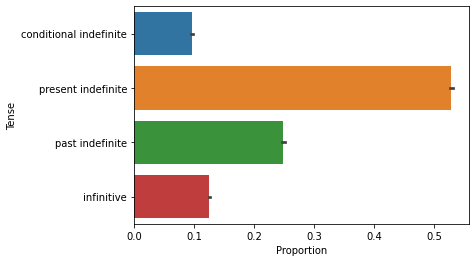

In [13]:
sns.barplot(data=df.reset_index().melt(id_vars='Film', var_name='Tense', value_name='Proportion'), y='Tense', x='Proportion', orient='h')